In [3]:
import sys
sys.path.append('C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import logging
import cProfile
from tqdm.notebook import tqdm

import utils
import config
import strat_test
importlib.reload(utils)
importlib.reload(config)
importlib.reload(strat_test)

<module 'strat_test' from 'C:\\Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/个人/量化交易/backtest\\strat_test\\__init__.py'>

In [4]:
# config
cfg = config.config
blacklist = cfg['universe']['black']
quote_dir = cfg['folder']['quote']

factor_dir = 'C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A04_指数编制/quote/QUOTE_INDUSTRY/assembler'

end_date = '2025-12-31'

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

plt.rcParams['figure.figsize'] = (12, 3)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.grid'] = True
%config InlineBackend.figure_format = 'retina'

INFO:__main__:Read FG with 2759 rows


INFO:__main__:Read hc with 2449 rows
INFO:__main__:Read i with 2553 rows
INFO:__main__:Read j with 3159 rows
INFO:__main__:Read jm with 2688 rows
INFO:__main__:Read rb with 3467 rows
INFO:__main__:Read SF with 2353 rows
INFO:__main__:Read SM with 2353 rows
INFO:__main__:Read SA with 1054 rows


<Axes: xlabel='date'>

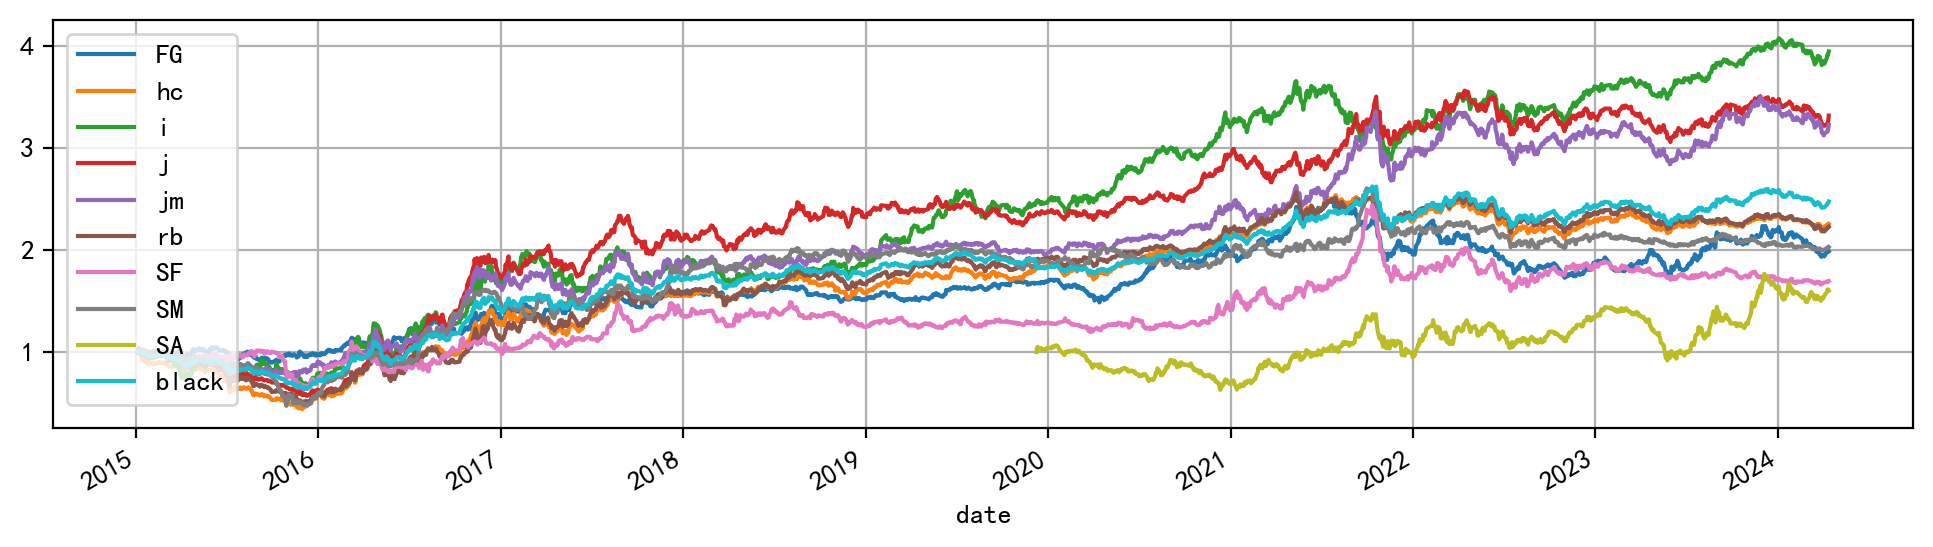

In [5]:
# futures data from quote basic
opens = pd.DataFrame()

data_name = "open777"

for v in blacklist:
    dir_path = os.path.join(quote_dir, "QUOTE_BASIC", "assembler", data_name, f"{v}.csv")
    df = pd.read_csv(dir_path, index_col=0, parse_dates=True)
    df = df.loc[:end_date]
    opens[v] = df[data_name]
    logger.info(f"Read {v} with {len(df)} rows")

# add black index
index_dir = os.path.join(quote_dir, "INDEX/black_open_index_qb.csv")
black_index = pd.read_csv(index_dir, index_col=0, parse_dates=True)
opens["black"] = black_index

prices = pd.read_csv("data/price/black_prices.csv", index_col=0, parse_dates=True)
prices = prices.loc[:end_date]
prices["black"] = prices.mean(axis=1)
prices.plot()

## I_S002811507
汽车产量:乘用车:累计同比

Text(0.5, 1.0, 'I_S002811507')

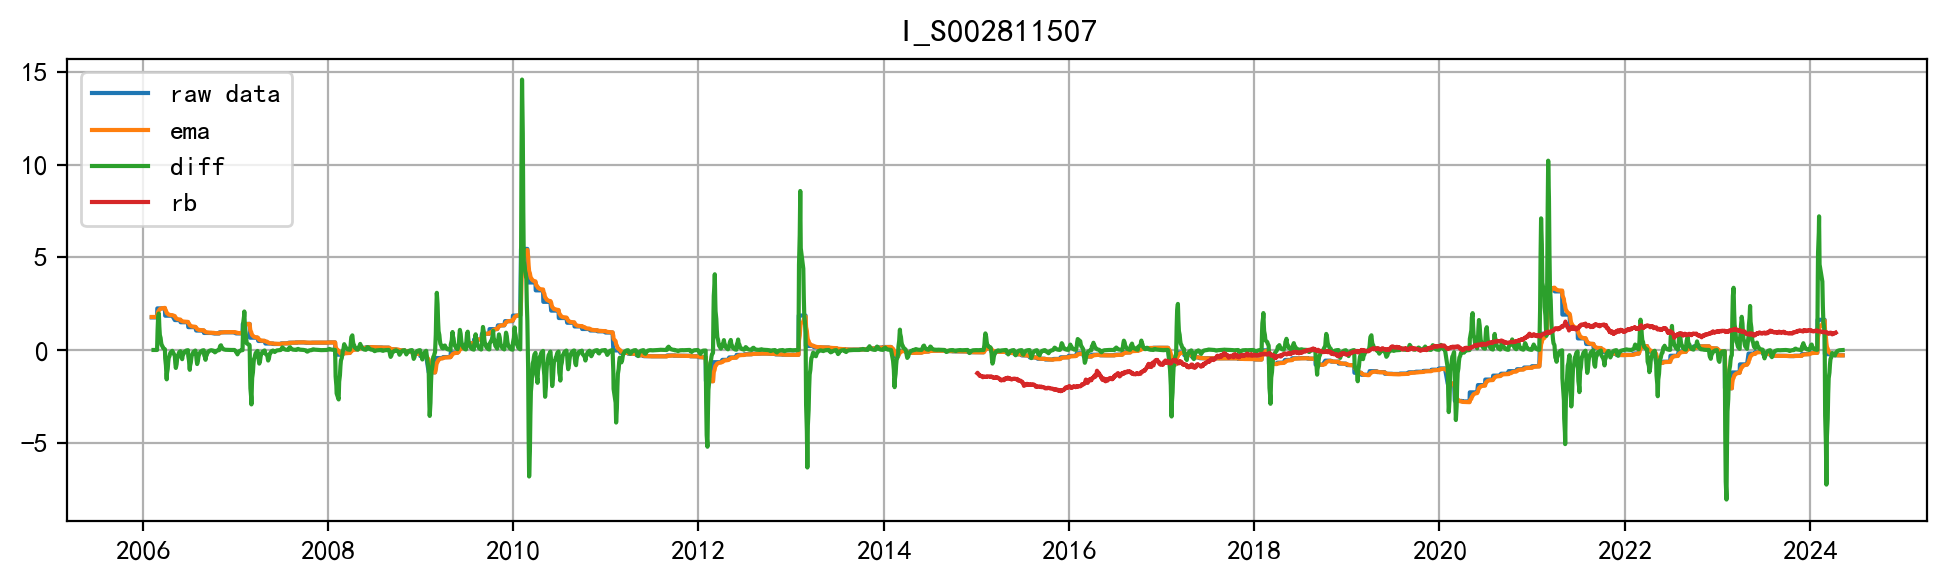

In [6]:
name = "I_S002811507"
I_S002811507 = pd.read_csv(f'{factor_dir}/auto.csv',index_col=0, parse_dates=True)[name]
I_S002811507 = I_S002811507.loc[:end_date]
plt.plot(utils.scale(I_S002811507), label='raw data')
I_S002811507 = utils.ema(I_S002811507, 1/5)
plt.plot(utils.scale(I_S002811507), label='ema')
I_S002811507 = I_S002811507.diff(5)
plt.plot(utils.scale(I_S002811507), label='diff')
# I_S002811507 = utils.ts_rank(I_S002811507, 90, "dynamic") - 0.5
# plt.plot(utils.scale(I_S002811507, how='divstd'), label='rank')
plt.plot(utils.scale(prices['hc'], how='standard'), label='rb')
plt.legend()
plt.title(name)

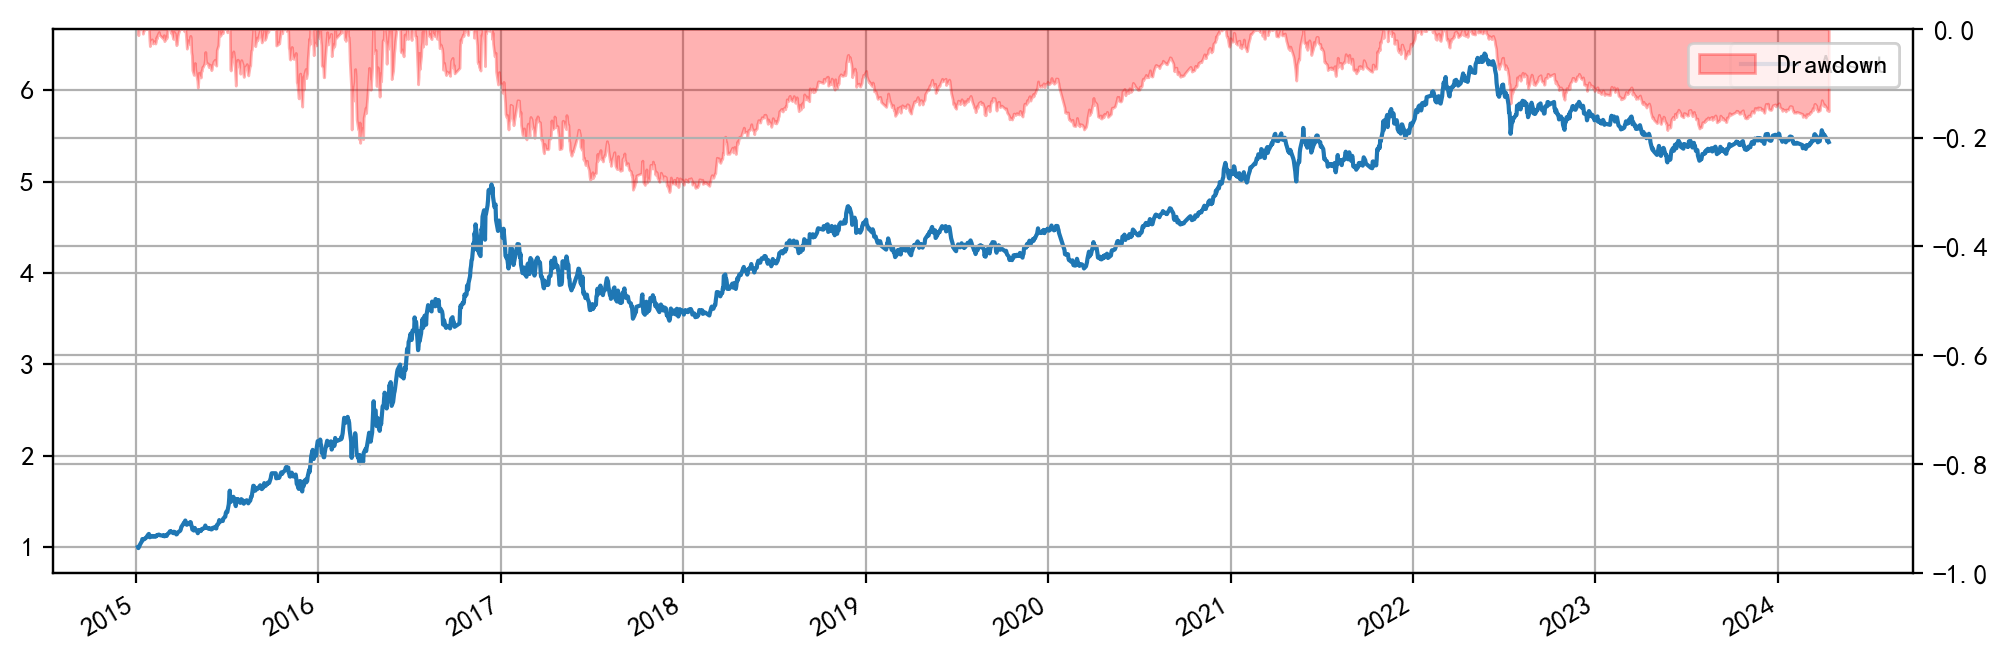

In [7]:
posi = I_S002811507 / I_S002811507.abs()
posi = posi.replace(np.nan, 0)
price, posi = prices['hc'].dropna().align(posi, join='inner')
price.name = posi.name = "hc"
nwm = strat_test.NetWorthMaker(price, posi)
nwm.plot()

In [8]:
def test_params(name, end_date, ema_alpha=1/20, ts_rank_w=75):
    factor = pd.read_csv(f'{factor_dir}/auto.csv',index_col=0, parse_dates=True)[name]
    factor = factor.loc[:pd.to_datetime(end_date)]
    factor = utils.ema(factor, ema_alpha)
    factor = utils.ts_rank(factor, ts_rank_w, "dynamic") - 0.5
    posi = factor / factor.abs()
    posi = posi.replace(np.nan, 0)
    price, posi = prices['hc'].dropna().align(posi, join='inner')
    price.name = posi.name = 'hc'
    nwm = strat_test.NetWorthMaker(price, posi)
    return nwm, posi

In [167]:
alphas = range(2, 10)
ws = range(5, 101, 5)
rets = pd.DataFrame(index=alphas, columns=ws)

for alpha in tqdm(alphas):
    for w in ws:
        nwm, _ = test_params(name, end_date, ema_alpha=1/alpha, ts_rank_w=w)
        rets.loc[alpha, w] = nwm.get_total().loc['calmar']

  0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
rets.apply(pd.to_numeric).style.background_gradient(axis=None).format("{:.2f}")

NameError: name 'rets' is not defined

,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2015,244,60.66,157.24,26.60,10.79,14.57,5.91,1.23,25.00,74.18,99.18
2016,244,54.92,120.02,40.96,16.02,7.49,2.93,1.64,84.02,15.57,99.59
2017,244,46.31,-20.46,22.87,29.90,-0.68,-0.89,2.87,18.44,80.33,98.77
2018,243,53.09,17.12,12.69,7.40,2.31,1.35,2.47,35.80,63.37,99.18
2019,244,47.54,-5.44,9.77,12.71,-0.43,-0.56,1.23,55.74,43.85,99.59
2020,243,58.44,14.42,9.75,10.40,1.39,1.48,0.82,74.49,25.51,100.00
2021,243,53.09,17.80,13.01,8.68,2.05,1.37,0.41,30.04,69.55,99.59
2022,242,47.93,0.94,10.96,10.54,0.09,0.09,1.65,64.46,34.30,98.76
2023,242,47.11,-4.45,7.45,9.54,-0.47,-0.60,1.24,46.28,53.31,99.59
2024,66,42.42,-4.72,3.20,4.91,-0.96,-1.47,1.52,65.15,34.85,100.00


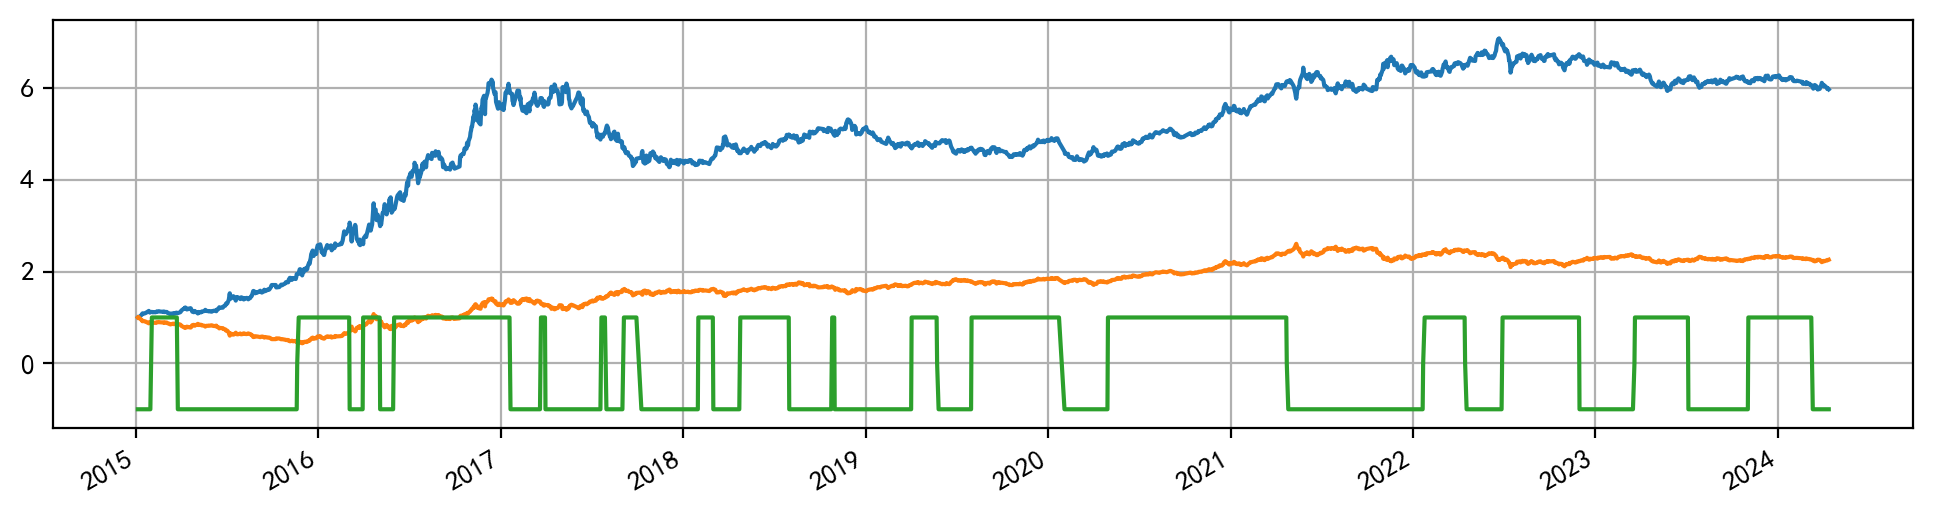

In [10]:
nwm, posi_1 = test_params(name, end_date, ema_alpha=1/3, ts_rank_w=65)
plt.plot(nwm.get_networth(), label='networth')
plt.plot(utils.scale(prices['hc'], "1stvalue"))
posi_1.plot()
nwm.get_annual()

## I_M005383066
汽车产量:乘用车:当月同比

Text(0.5, 1.0, 'I_M005383066')

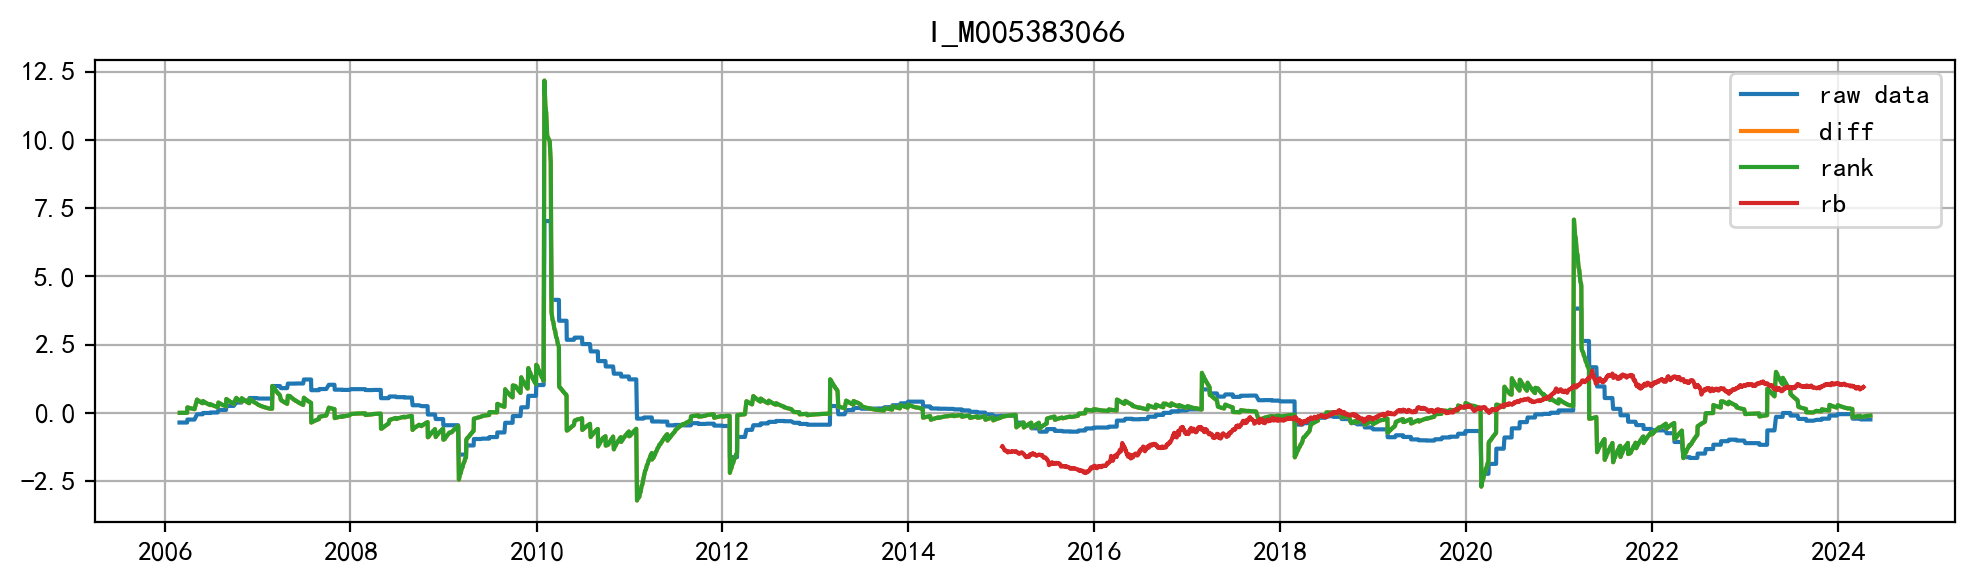

In [11]:
name = "I_M005383066"
I_M005383066 = pd.read_csv(f'{factor_dir}/auto.csv',index_col=0, parse_dates=True)[name]
I_M005383066 = I_M005383066.loc[:end_date]
plt.plot(utils.scale(I_M005383066), label='raw data')
I_M005383066 = utils.ema(I_M005383066, 1/50)
I_M005383066 = I_M005383066.diff()
plt.plot(utils.scale(I_M005383066), label='diff')
# plt.plot(utils.scale(I_M005383066), label='ema')
# I_M005383066 = utils.ts_rank(I_M005383066, 100, "dynamic") - 0.5
plt.plot(utils.scale(I_M005383066, how='divstd'), label='rank')
plt.plot(utils.scale(prices['hc'], how='standard'), label='rb')
plt.legend()
plt.title(name)

In [12]:
def test_params(name, end_date, ema_alpha=1/20):
    factor = pd.read_csv(f'{factor_dir}/auto.csv',index_col=0, parse_dates=True)[name]
    factor = factor.loc[:pd.to_datetime(end_date)]
    factor = utils.ema(factor, ema_alpha)
    factor = factor.diff()
    posi = factor / factor.abs()
    posi = posi.replace(np.nan, 0)
    price, posi = prices['hc'].dropna().align(posi, join='inner')
    price.name = posi.name = 'hc'
    nwm = strat_test.NetWorthMaker(price, posi)
    return nwm, posi

In [77]:
alphas = range(5, 101, 5)
rets = pd.DataFrame(columns=alphas, index=[0])

for alpha in tqdm(alphas):
    nwm, _ = test_params(name, end_date, ema_alpha=1/alpha)
    rets.loc[0, alpha] = nwm.get_total().loc['calmar']

  0%|          | 0/20 [00:00<?, ?it/s]

In [78]:
rets.apply(pd.to_numeric).style.background_gradient(axis=None).format("{:.2f}")

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100
0,1.16,0.98,2.45,2.16,2.07,2.76,2.63,2.65,3.83,4.66,4.14,4.14,4.14,4.32,4.32,3.80,1.52,1.52,1.52,1.52


,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2015,244,61.89,188.87,26.60,10.79,17.50,7.10,0.41,9.84,90.16,100.0
2016,244,54.92,120.23,41.01,30.54,3.94,2.93,0.00,100.00,0.00,100.0
2017,244,51.64,19.84,23.05,17.47,1.14,0.86,0.41,75.41,24.59,100.0
2018,243,49.38,8.58,12.72,11.97,0.72,0.67,0.82,8.64,91.36,100.0
2019,244,51.23,-6.84,9.81,14.78,-0.46,-0.70,0.41,25.41,74.59,100.0
2020,243,58.44,23.36,9.70,5.95,3.92,2.41,0.82,82.72,17.28,100.0
2021,243,53.50,18.27,13.05,8.68,2.10,1.40,0.41,32.10,67.90,100.0
2022,242,51.24,8.94,10.96,8.04,1.11,0.82,0.41,33.88,66.12,100.0
2023,242,49.17,-2.41,7.46,9.61,-0.25,-0.32,0.41,76.03,23.97,100.0
2024,66,46.97,-1.54,3.25,3.04,-0.51,-0.47,1.52,54.55,45.45,100.0


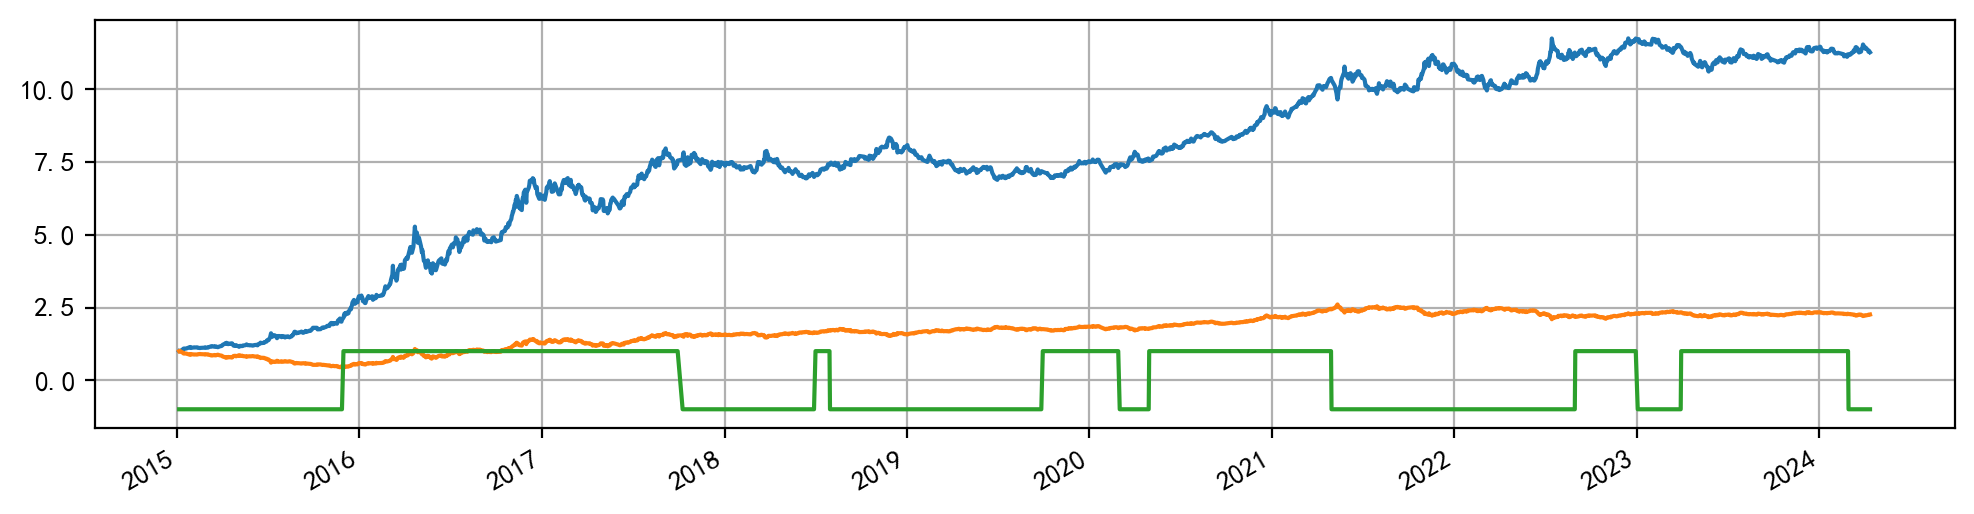

In [13]:
nwm, posi_2 = test_params(name, end_date, ema_alpha=1/50)
plt.plot(nwm.get_networth(), label='networth')
plt.plot(utils.scale(prices['hc'], "1stvalue"))
posi_2.plot()
nwm.get_annual()

## I_M005383065
发动机:产量:当月同比

Text(0.5, 1.0, 'I_M005383065')

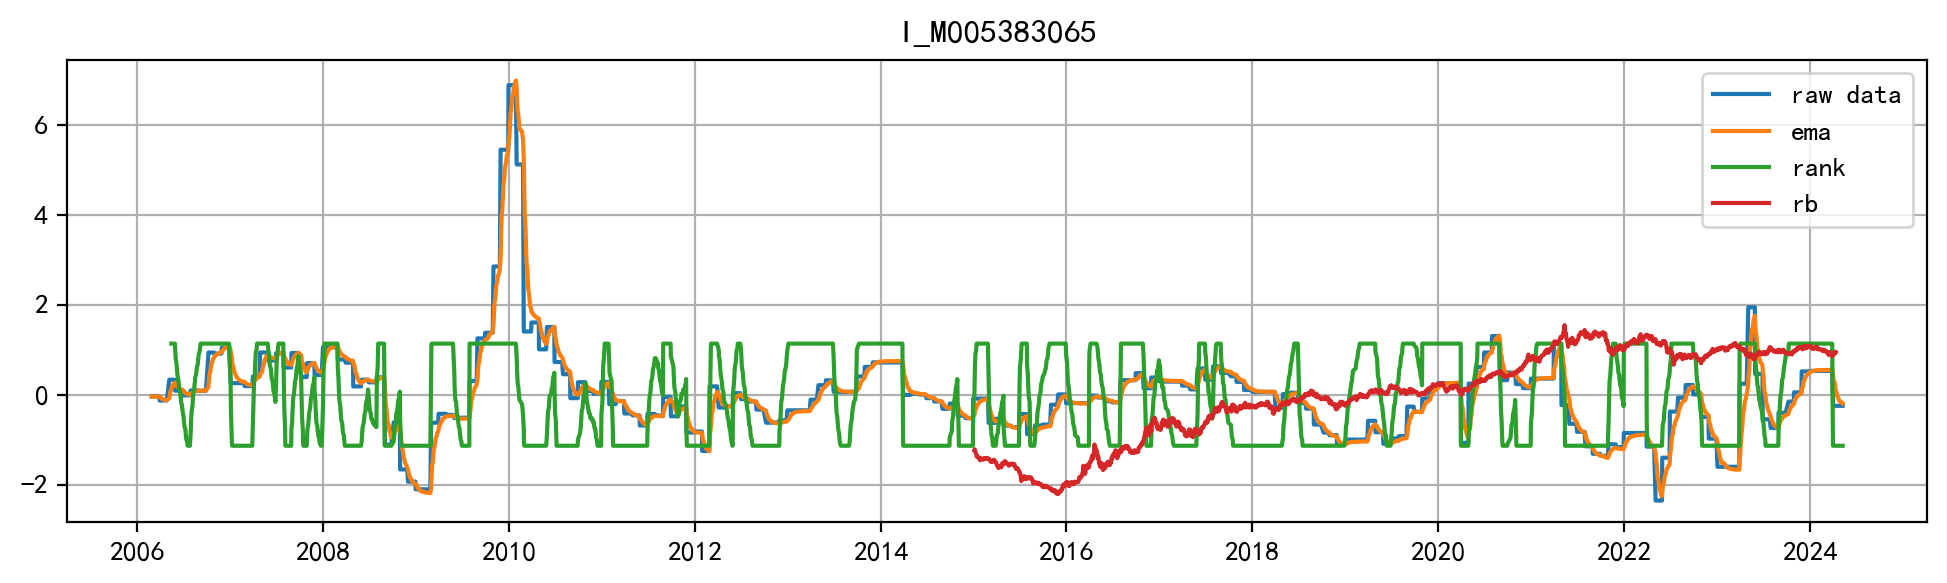

In [14]:
name = "I_M005383065"
I_M005383065 = pd.read_csv(f'{factor_dir}/auto.csv',index_col=0, parse_dates=True)[name]
I_M005383065 = I_M005383065.loc[:end_date]
plt.plot(utils.scale(I_M005383065), label='raw data')
I_M005383065 = utils.ema(I_M005383065, 1/10)
# I_M005383065 = I_M005383065.diff()
# plt.plot(utils.scale(I_M005383065), label='diff')
plt.plot(utils.scale(I_M005383065), label='ema')
I_M005383065 = utils.ts_rank(I_M005383065, 50, "dynamic") - 0.5
plt.plot(utils.scale(I_M005383065, how='divstd'), label='rank')
plt.plot(utils.scale(prices['hc'], how='standard'), label='rb')
plt.legend()
plt.title(name)

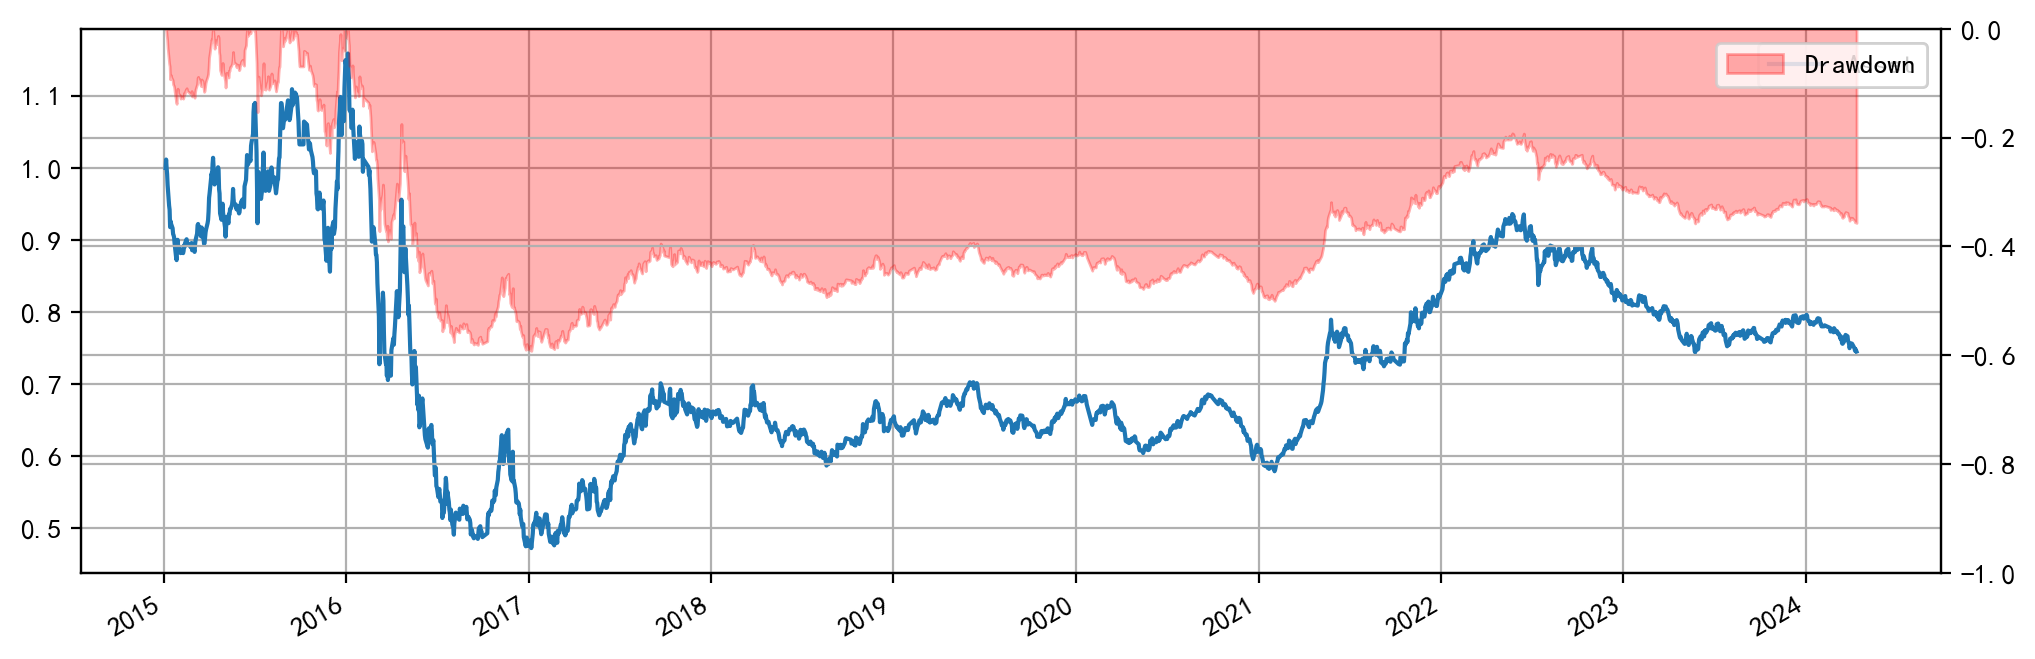

In [15]:
posi = I_M005383065 / I_M005383065.abs()
posi = posi.replace(np.nan, 0)
price, posi = prices['hc'].dropna().align(posi, join='inner')
price.name = posi.name = "hc"
nwm = strat_test.NetWorthMaker(price, posi)
nwm.plot()

## I_S005566895
集装箱:出口金额:当月同比

Text(0.5, 1.0, 'I_S005566895')

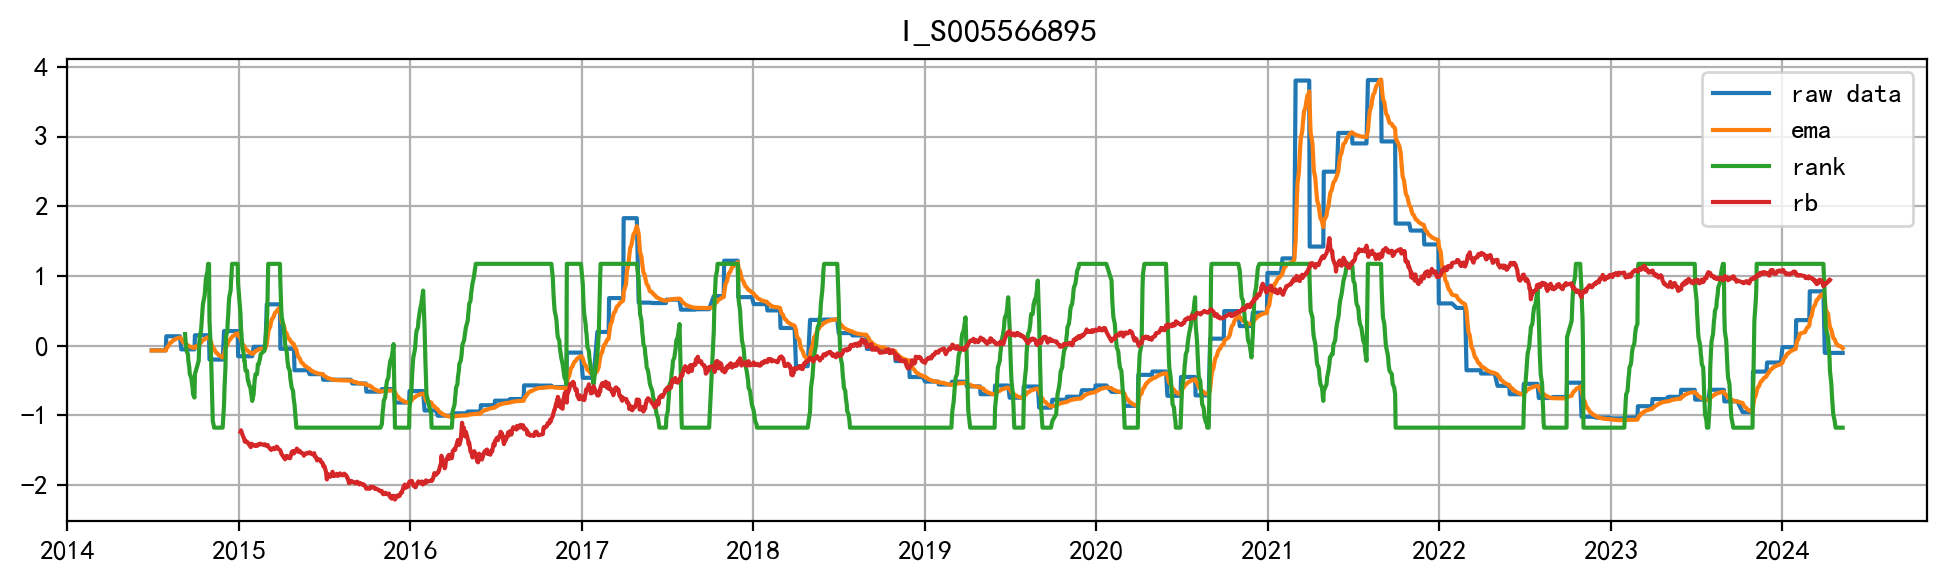

In [16]:
name = "I_S005566895"
I_S005566895 = pd.read_csv(f'{factor_dir}/mech_equip.csv',index_col=0, parse_dates=True)[name]
I_S005566895 = I_S005566895.loc[:end_date]
plt.plot(utils.scale(I_S005566895), label='raw data')
I_S005566895 = utils.ema(I_S005566895, 1/10)
plt.plot(utils.scale(I_S005566895), label='ema')
# I_S005566895 = I_S005566895.diff()
# plt.plot(utils.scale(I_S005566895), label='diff')
I_S005566895 = utils.ts_rank(I_S005566895, 50, "dynamic") - 0.5
plt.plot(utils.scale(I_S005566895, how='divstd'), label='rank')
plt.plot(utils.scale(prices['hc'], how='standard'), label='rb')
plt.legend()
plt.title(name)

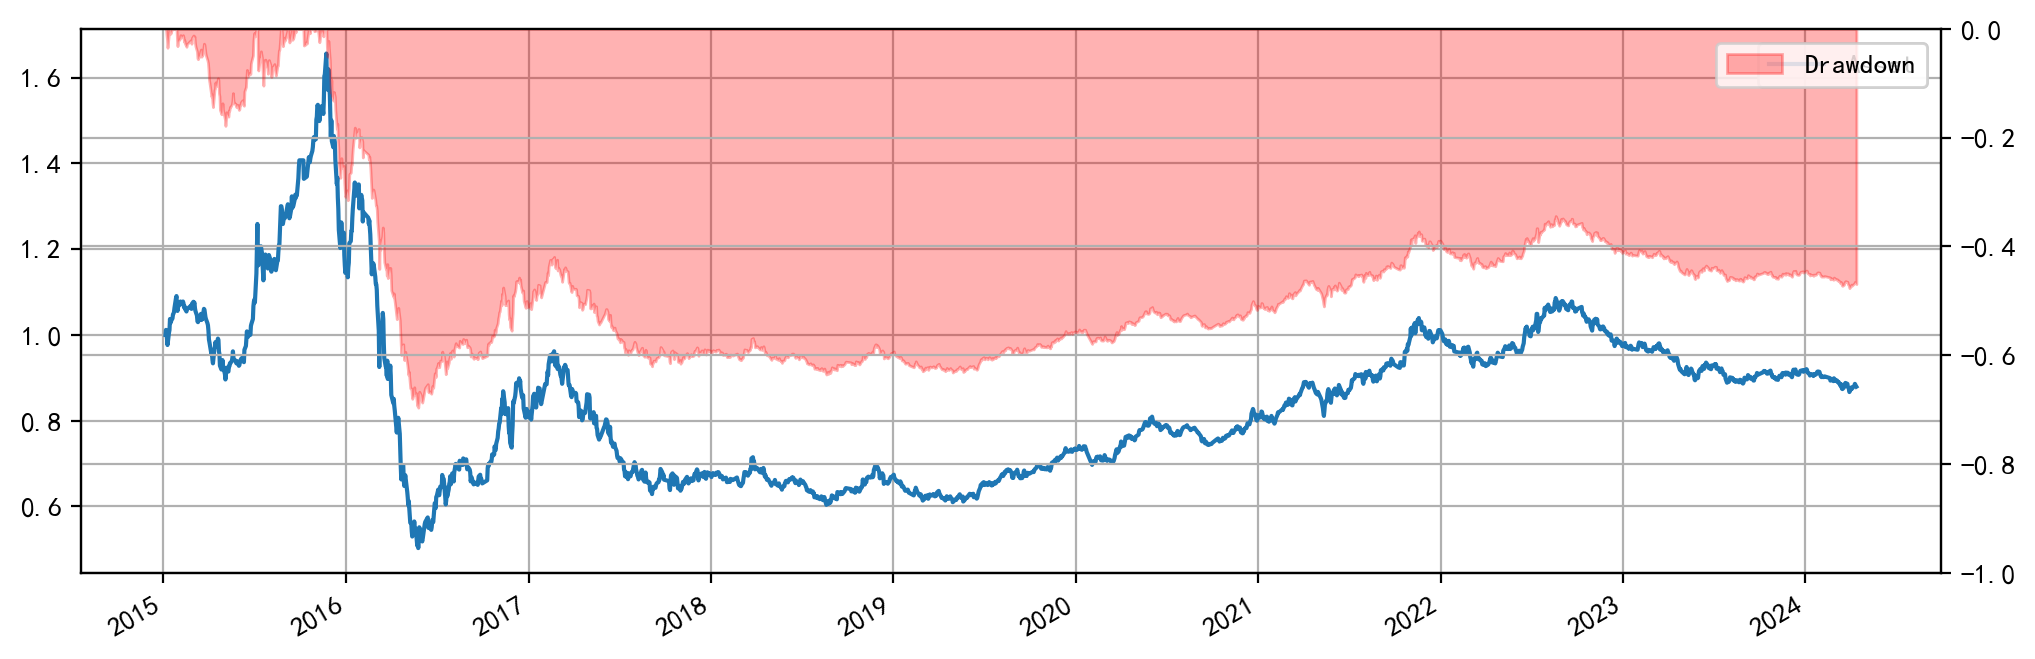

In [17]:
posi = I_S005566895 / I_S005566895.abs()
posi = posi.replace(np.nan, 0)
price, posi = prices['hc'].dropna().align(posi, join='inner')
price.name = posi.name = "hc"
nwm = strat_test.NetWorthMaker(price, posi)
nwm.plot()

## I_S006699504
制热:空气源热泵:销量:当月同比

Text(0.5, 1.0, 'I_S006699504')

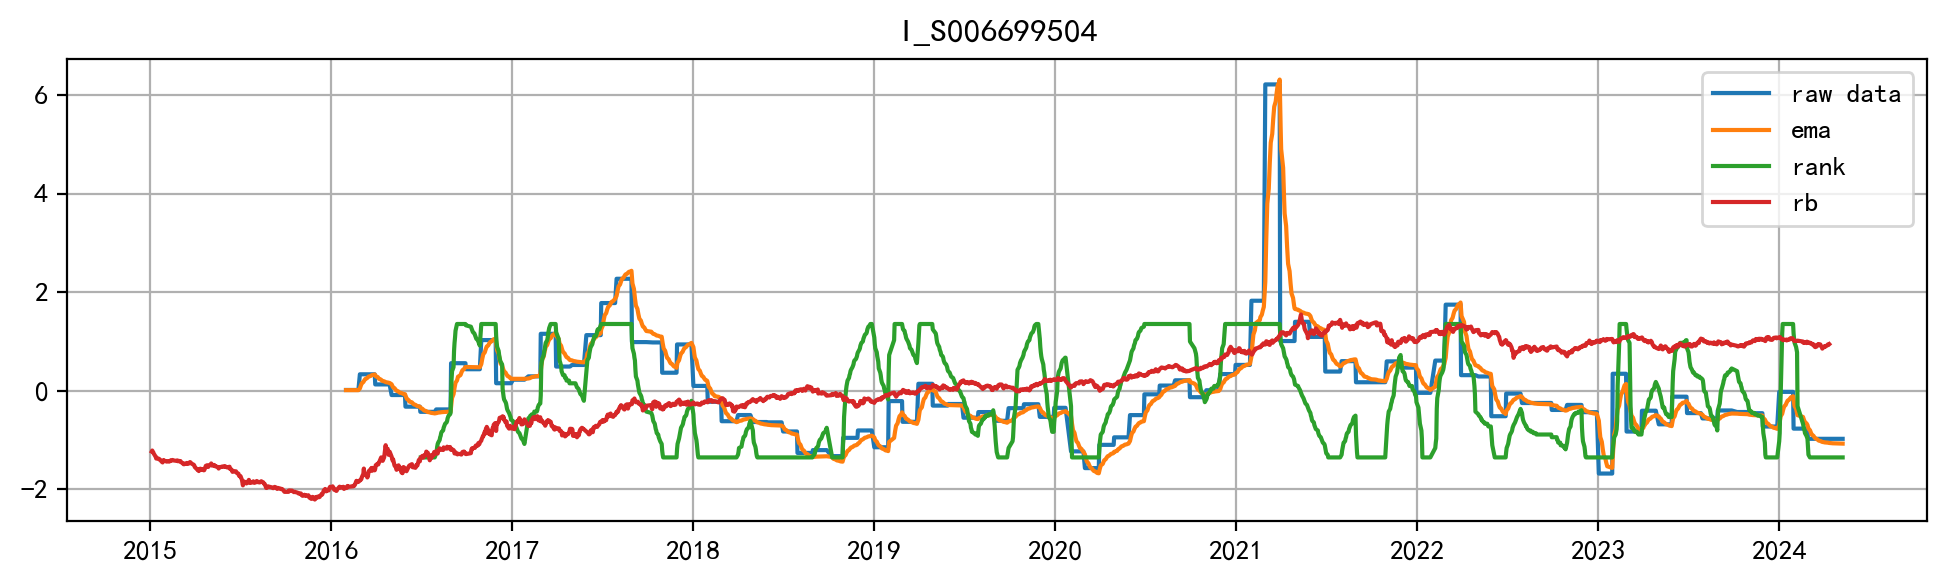

In [18]:
name = "I_S006699504"
I_S006699504 = pd.read_csv(f'{factor_dir}/mech_equip.csv',index_col=0, parse_dates=True)[name]
I_S006699504 = I_S006699504.loc[:end_date]
plt.plot(utils.scale(I_S006699504), label='raw data')
I_S006699504 = utils.ema(I_S006699504, 1/10)
plt.plot(utils.scale(I_S006699504), label='ema')
# I_S006699504 = I_S006699504.diff()
# plt.plot(utils.scale(I_S006699504), label='diff')
I_S006699504 = utils.ts_rank(I_S006699504, 100, "dynamic") - 0.5
plt.plot(utils.scale(I_S006699504, how='divstd'), label='rank')
plt.plot(utils.scale(prices['hc'], how='standard'), label='rb')
plt.legend()
plt.title(name)

In [19]:
def test_params(name, end_date, ema_alpha=1/20, ts_rank_w=75):
    factor = pd.read_csv(f'{factor_dir}/mech_equip.csv',index_col=0, parse_dates=True)[name]
    factor = factor.loc[:pd.to_datetime(end_date)]
    factor = utils.ema(factor, ema_alpha)
    factor = utils.ts_rank(factor, ts_rank_w, "dynamic") - 0.5
    posi = factor / factor.abs()
    posi = posi.replace(np.nan, 0)
    price, posi = prices['hc'].dropna().align(posi, join='inner')
    price.name = posi.name = 'hc'
    nwm = strat_test.NetWorthMaker(price, posi)
    return nwm, posi

In [125]:
alphas = range(5, 101, 5)
ws = range(5, 201, 5)
rets = pd.DataFrame(index=alphas, columns=ws)

for alpha in tqdm(alphas):
    for w in ws:
        nwm, _ = test_params(name, end_date, ema_alpha=1/alpha, ts_rank_w=w)
        rets.loc[alpha, w] = nwm.get_total().loc['calmar']

  0%|          | 0/20 [00:00<?, ?it/s]

In [126]:
rets.apply(pd.to_numeric).style.background_gradient(axis=None).format("{:.2f}")

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200
5,0.01,0.15,0.15,0.15,0.21,0.15,0.16,0.20,0.10,0.42,0.29,0.34,0.23,0.19,0.19,0.21,0.36,0.24,0.46,0.78,0.96,1.01,0.42,0.85,1.21,1.22,1.23,0.74,0.72,0.89,1.23,1.17,0.95,0.60,0.48,0.24,0.11,0.17,0.10,0.08
10,-0.02,0.07,0.19,0.38,0.26,0.23,0.28,0.37,0.17,0.32,0.14,0.10,0.12,0.14,0.16,0.17,0.25,0.25,0.26,0.69,0.94,0.69,0.54,0.61,0.61,0.46,0.35,0.54,0.76,0.52,1.49,1.54,1.27,1.16,0.93,0.48,0.29,0.14,0.14,0.17
15,0.26,0.39,0.42,0.33,0.31,0.28,0.21,0.11,0.09,0.30,0.39,0.33,0.23,0.23,0.13,0.02,0.12,0.13,0.25,0.34,0.43,0.55,0.30,0.66,0.34,0.56,0.83,0.75,0.80,0.93,1.12,0.96,0.86,0.51,0.38,0.30,0.23,0.30,0.17,0.15
20,0.10,0.39,0.31,0.28,0.34,0.22,0.33,0.29,0.53,0.54,0.37,0.36,0.25,0.11,-0.01,0.06,0.11,0.18,0.30,0.38,0.77,1.09,0.92,1.00,1.08,1.18,1.05,1.55,1.54,0.87,0.81,0.60,0.45,0.56,0.49,0.38,0.36,0.26,0.26,0.31
25,0.18,0.43,0.45,0.44,0.44,0.35,0.42,0.58,0.60,0.45,0.41,0.43,0.09,0.05,0.02,0.06,0.19,0.32,0.69,0.98,1.06,1.50,1.02,1.38,1.43,1.27,1.59,1.14,1.05,0.84,0.59,0.44,0.60,0.61,0.60,0.63,0.39,0.28,0.27,0.29
30,0.33,0.50,0.62,0.50,0.63,0.53,0.75,0.84,0.65,0.57,0.46,0.25,0.17,0.14,0.05,0.18,0.45,0.57,0.72,0.93,1.04,0.86,1.10,1.31,0.94,0.84,1.15,0.86,0.88,0.58,0.71,0.69,0.66,0.83,0.70,0.46,0.25,0.28,0.26,0.26
35,0.37,0.55,0.66,0.47,0.57,0.67,1.07,0.82,0.55,0.47,0.27,0.13,0.18,0.17,0.08,0.33,0.56,0.57,0.63,0.93,0.84,1.34,0.95,0.61,0.74,0.97,0.84,0.88,0.72,0.83,0.58,0.68,0.81,0.77,0.43,0.26,0.26,0.31,0.24,0.26
40,0.33,0.49,0.72,0.50,0.60,0.89,0.89,0.64,0.50,0.37,0.14,0.24,0.21,0.21,0.22,0.30,0.51,0.52,0.71,0.85,0.90,1.12,0.48,0.66,0.71,0.84,0.84,0.91,0.70,0.68,0.82,0.90,0.78,0.49,0.35,0.35,0.38,0.26,0.35,0.50
45,0.35,0.48,0.67,0.49,0.70,0.98,0.85,0.48,0.50,0.28,0.09,0.19,0.19,0.23,0.18,0.31,0.60,0.54,0.49,0.63,0.97,0.51,0.52,0.62,0.76,1.02,0.73,0.57,0.79,0.91,0.89,0.89,0.54,0.53,0.49,0.42,0.36,0.41,0.56,0.47
50,0.36,0.49,0.67,0.56,0.70,0.93,0.75,0.49,0.37,0.14,0.15,0.15,0.16,0.20,0.19,0.37,0.54,0.40,0.44,0.83,0.62,0.60,0.46,0.58,0.74,0.90,0.78,1.00,0.96,0.70,0.76,0.66,0.72,0.71,0.47,0.47,0.48,0.52,0.47,0.26


,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2016,89,58.43,40.71,18.12,10.24,3.98,2.25,1.12,80.90,19.10,100.00
2017,244,51.64,27.35,22.85,16.82,1.63,1.20,2.05,74.18,25.00,99.18
2018,243,46.91,-1.27,12.72,17.35,-0.07,-0.10,0.41,6.58,93.00,99.59
2019,244,54.51,22.06,9.73,3.76,5.87,2.27,2.05,63.93,34.84,98.77
2020,243,52.26,4.65,9.78,11.35,0.41,0.48,1.23,62.55,37.04,99.59
2021,243,53.91,17.62,13.00,11.14,1.58,1.36,0.82,42.80,56.38,99.18
2022,242,47.11,-2.56,10.97,9.19,-0.28,-0.23,0.83,25.21,74.79,100.00
2023,242,49.59,4.41,7.43,4.29,1.03,0.59,2.48,39.67,59.09,98.76
2024,66,54.55,0.73,3.26,2.53,0.29,0.22,3.03,34.85,65.15,100.00
total,1856,51.45,22.10,14.56,18.03,1.23,1.52,1.45,46.39,52.96,99.35


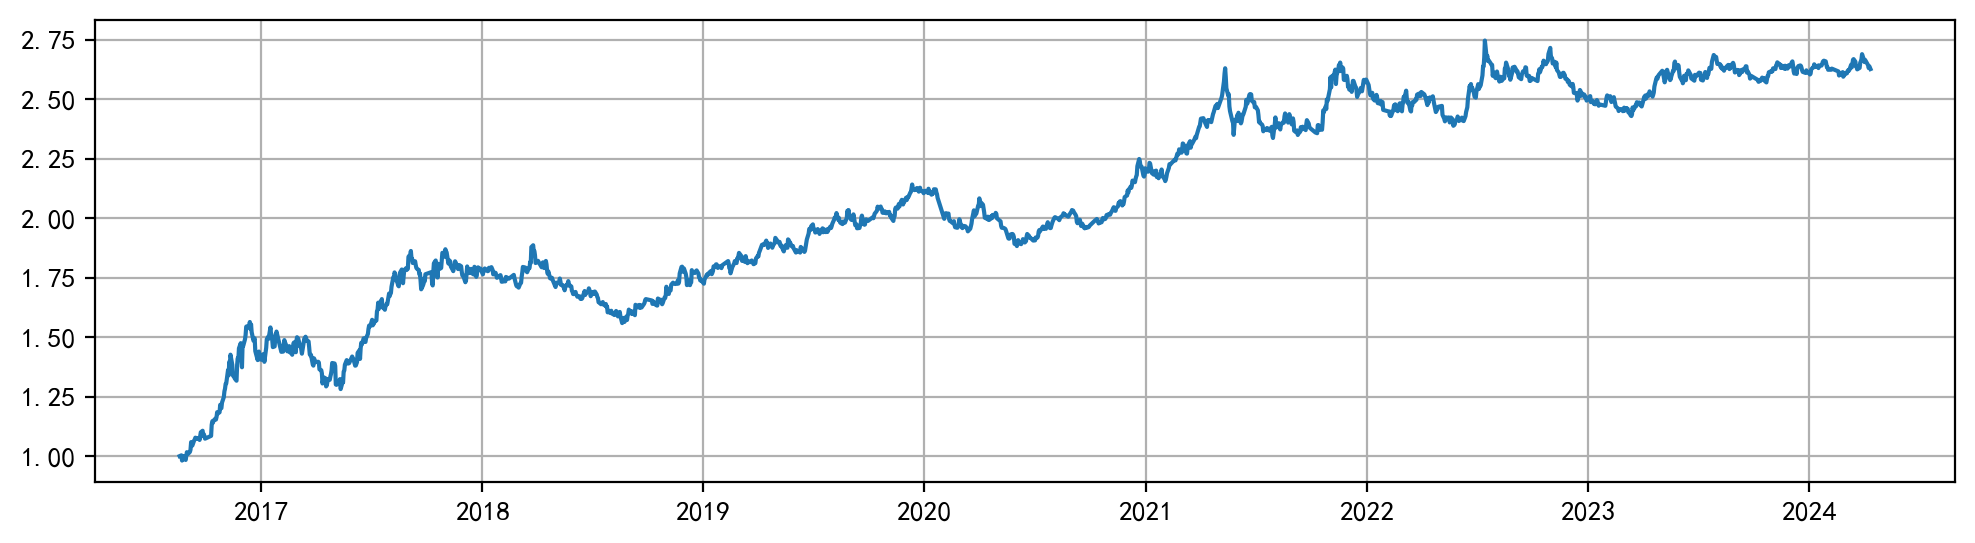

In [20]:
nwm, posi_3 = test_params(name, end_date, ema_alpha=1/25, ts_rank_w=135)
plt.plot(nwm.get_networth(), label='networth')
nwm.get_annual()
# plt.plot(utils.scale(prices['rb'], "1stvalue"))
# posi_2.plot()

## I_S005951771
销量:工程机械行业:合计:累计同比

Text(0.5, 1.0, 'I_S005951771')

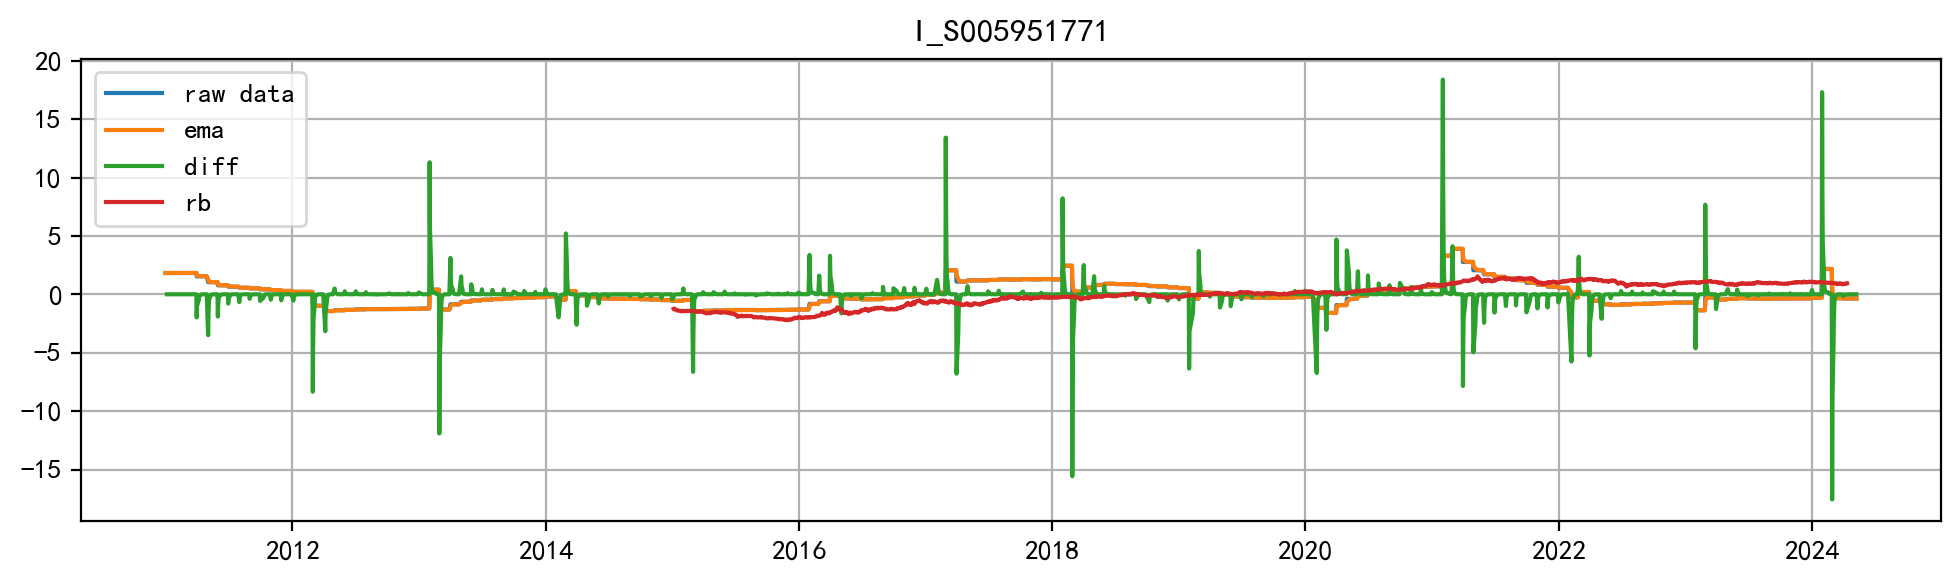

In [21]:
name = "I_S005951771"
I_S005951771 = pd.read_csv(f'{factor_dir}/mech_equip.csv',index_col=0, parse_dates=True)[name]
I_S005951771 = I_S005951771.loc[:end_date]
plt.plot(utils.scale(I_S005951771), label='raw data')
I_S005951771 = utils.ema(I_S005951771, 1/2)
plt.plot(utils.scale(I_S005951771), label='ema')
I_S005951771 = I_S005951771.diff()
plt.plot(utils.scale(I_S005951771), label='diff')
# I_S005951771 = utils.ts_rank(I_S005951771, 100, "dynamic") - 0.5
# plt.plot(utils.scale(I_S005951771, how='divstd'), label='rank')
plt.plot(utils.scale(prices['hc'], how='standard'), label='rb')
plt.legend()
plt.title(name)

In [22]:
def test_params(name, end_date, ema_alpha=1/20):
    factor = pd.read_csv(f'{factor_dir}/mech_equip.csv',index_col=0, parse_dates=True)[name]
    factor = factor.loc[:pd.to_datetime(end_date)]
    factor = utils.ema(factor, ema_alpha)
    factor = factor.diff()
    posi = factor / factor.abs()
    posi = posi.replace(np.nan, 0)
    price, posi = prices['hc'].dropna().align(posi, join='inner')
    price.name = posi.name = 'hc'
    nwm = strat_test.NetWorthMaker(price, posi)
    return nwm, posi

In [149]:
alphas = range(5, 101, 5)
rets = pd.DataFrame(columns=alphas, index=[0])

for alpha in tqdm(alphas):
    nwm, _ = test_params(name, end_date, ema_alpha=1/alpha)
    rets.loc[0, alpha] = nwm.get_total().loc['calmar']

  0%|          | 0/20 [00:00<?, ?it/s]

In [150]:
rets.apply(pd.to_numeric).style.background_gradient(axis=None).format("{:.2f}")

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100
0,1.25,1.46,0.70,0.79,0.88,2.53,2.74,4.77,4.77,3.98,1.68,1.71,1.71,1.90,2.17,2.17,2.17,2.17,2.17,2.17


,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2015,244,62.30,189.62,26.60,10.79,17.57,7.13,1.23,15.98,84.02,100.0
2016,244,54.92,120.23,41.01,30.54,3.94,2.93,0.00,100.00,0.00,100.0
2017,244,51.23,22.39,23.05,17.47,1.28,0.97,0.00,100.00,0.00,100.0
2018,243,51.03,12.96,12.71,12.19,1.06,1.02,1.65,23.46,76.54,100.0
2019,244,50.41,-11.36,9.79,14.78,-0.77,-1.16,0.41,9.02,90.98,100.0
2020,243,59.67,20.75,9.72,10.40,1.99,2.14,0.82,83.13,16.87,100.0
2021,243,53.50,18.27,13.05,8.68,2.10,1.40,0.41,32.10,67.90,100.0
2022,242,51.65,6.46,10.96,10.14,0.64,0.59,0.41,25.21,74.79,100.0
2023,242,51.65,-0.45,7.47,8.93,-0.05,-0.06,0.83,91.74,8.26,100.0
2024,66,46.97,-1.54,3.25,3.04,-0.51,-0.47,1.52,54.55,45.45,100.0


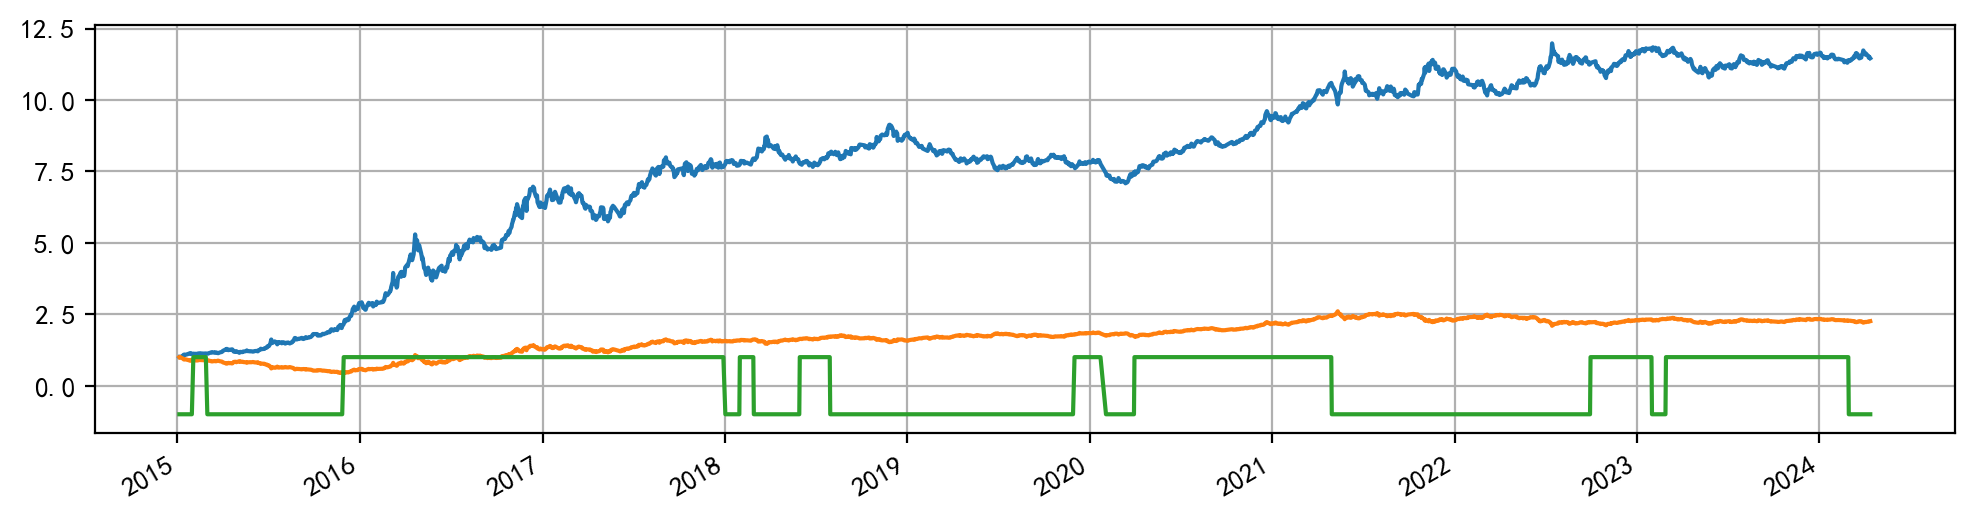

In [23]:
nwm, posi_4 = test_params(name, end_date, ema_alpha=1/40)
plt.plot(nwm.get_networth(), label='networth')
plt.plot(utils.scale(prices['hc'], "1stvalue"))
posi_4.plot()
nwm.get_annual()

## 需求合成并检验可用性
I_S002811507、I_M005383066、I_S005951771

<Axes: >

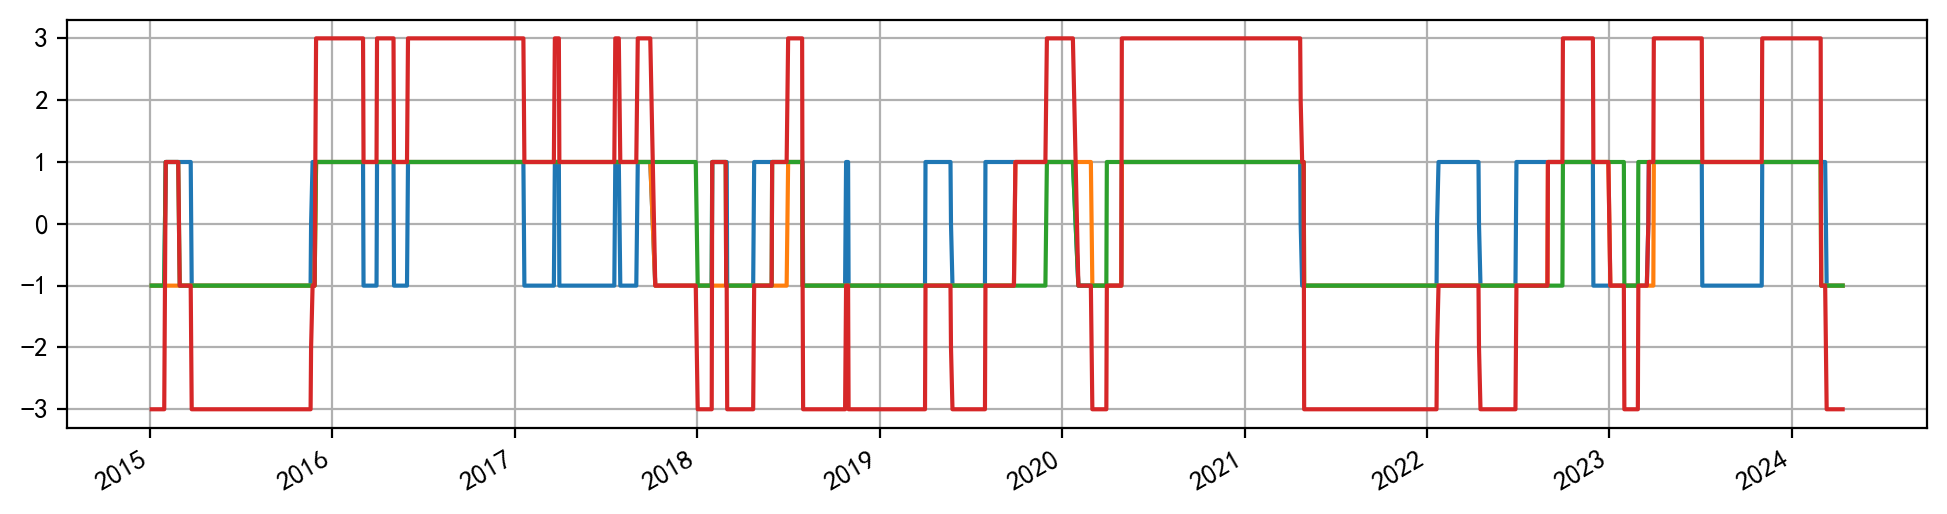

In [24]:
posi_1.plot()
posi_2.plot()
posi_4.plot()
(posi_1 + posi_2 + posi_4).plot()

,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2015,244,62.30,189.62,26.60,10.79,17.57,7.13,1.23,15.98,84.02,100.00
2016,244,54.92,120.23,41.01,30.54,3.94,2.93,0.00,100.00,0.00,100.00
2017,244,51.64,19.84,23.05,17.47,1.14,0.86,0.41,75.41,24.59,100.00
2018,243,51.03,12.96,12.71,12.19,1.06,1.02,1.65,23.46,76.54,100.00
2019,244,51.23,-6.84,9.81,14.78,-0.46,-0.70,0.41,25.41,74.59,100.00
2020,243,58.44,14.42,9.75,10.40,1.39,1.48,0.82,74.49,25.51,100.00
2021,243,53.50,18.27,13.05,8.68,2.10,1.40,0.41,32.10,67.90,100.00
2022,242,51.24,8.94,10.96,8.04,1.11,0.82,0.41,33.88,66.12,100.00
2023,242,50.41,-2.33,7.46,9.54,-0.24,-0.31,0.41,79.34,20.25,99.59
2024,66,46.97,-1.54,3.25,3.04,-0.51,-0.47,1.52,54.55,45.45,100.00


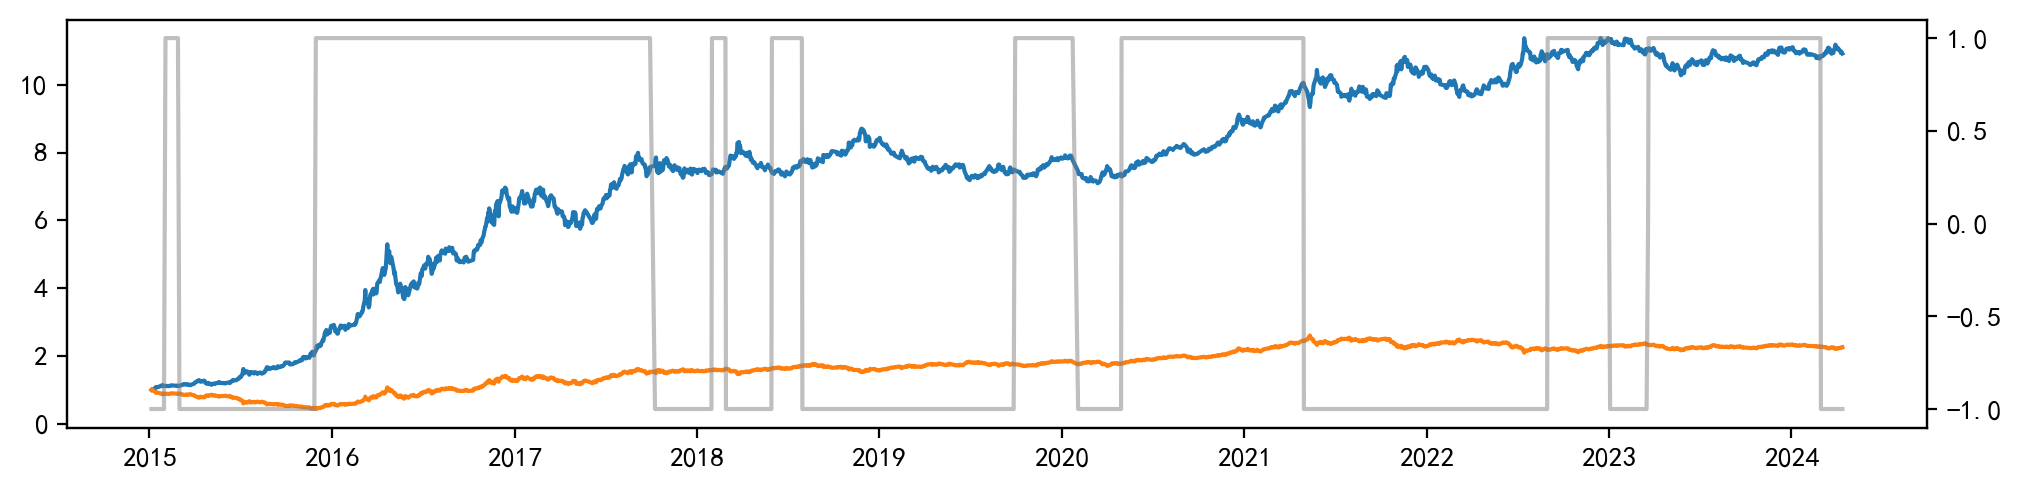

In [25]:
posi_comb = posi_1 + posi_2 + posi_4
posi_comb = posi_comb / posi_comb.abs()
posi_comb = posi_comb.replace(np.nan, 0)
price, posi_comb = prices['hc'].dropna().align(posi_comb, join='inner')
price.name = posi_comb.name = "hc"
nwm = strat_test.NetWorthMaker(price, posi_comb)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

posi_comb.plot(ax=ax2, color='gray', alpha=0.5, label='position')
ax1.plot(nwm.get_networth(), label='networth')
ax1.plot(utils.scale(prices['hc'], "1stvalue"), label='hc')

ax1.grid()
ax2.grid()
nwm.get_annual()

In [226]:
utils.few2crossing(posi_comb).to_csv("data/position/hc_demand.csv")

In [227]:
!python backtest.py "hc_d" "C:\Users\ifwha\OneDrive - CUHK-Shenzhen\桌面\工作\A06_策略研究\黑色板块策略\data\position\hc_demand.csv"

保存多头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\hc_d\hc_d_多头.csv
保存空头持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\hc_d\hc_d_空头.csv
保存全部持仓文件: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\hc_d\hc_d.csv
读取持仓文件生成净值: C:/Users/ifwha/OneDrive - CUHK-Shenzhen/桌面/工作/A06_策略研究/黑色板块策略/result\hc_d\hc_d.csv
Figure(1200x800)
年化收益率 年化波动率 夏普率 最大回撤  最长回撤期 年换手率
   27.177%    10.382% 2.6177 -15.083%         476  615.83%


In [26]:
net_worth = pd.read_csv('result/hc_d/历史净值.csv', index_col=0, parse_dates=True)
net_worth, posi_comb = net_worth.align(posi_comb, join='inner', axis=0)
sp = strat_test.StratPerf(net_worth, posi_comb)
sp.get_all()

,days,acc.%,ret.%,std.%,mdd.%,calmar,sharpe,tr.%,long.%,short.%,abs.%
2015,242,61.57,66.55,13.21,7.28,9.14,5.04,1.24,16.12,83.88,100.00
2016,244,54.92,41.36,18.37,15.08,2.74,2.25,0.00,100.00,0.00,100.00
2017,244,51.23,9.24,12.74,9.82,0.94,0.73,0.41,75.41,24.59,100.00
2018,243,50.62,7.16,7.93,8.39,0.85,0.90,1.65,23.46,76.54,100.00
2019,244,51.64,-3.02,6.54,9.61,-0.31,-0.46,0.41,25.41,74.59,100.00
2020,243,58.44,11.10,6.78,6.20,1.79,1.64,0.82,74.49,25.51,100.00
2021,243,53.50,16.43,9.48,6.32,2.60,1.73,0.41,32.10,67.90,100.00
2022,242,51.24,6.00,7.31,5.42,1.11,0.82,0.41,33.88,66.12,100.00
2023,241,50.62,-1.57,4.82,6.25,-0.25,-0.33,0.41,79.25,20.33,99.59
2024,66,46.97,-0.98,2.09,1.99,-0.49,-0.47,1.52,54.55,45.45,100.00


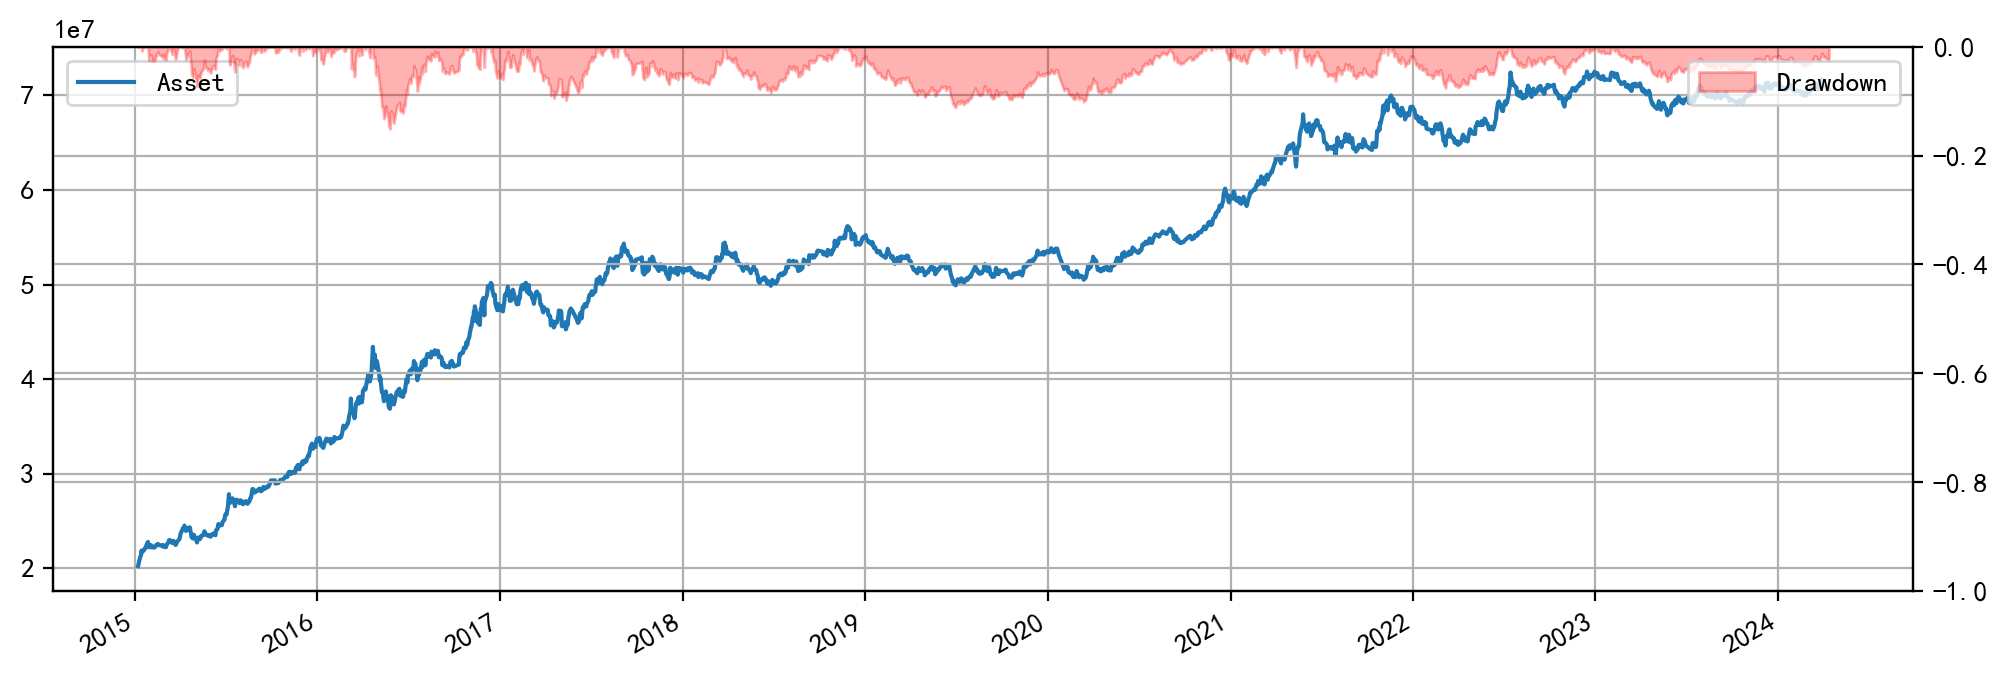

In [28]:
sp.plot()

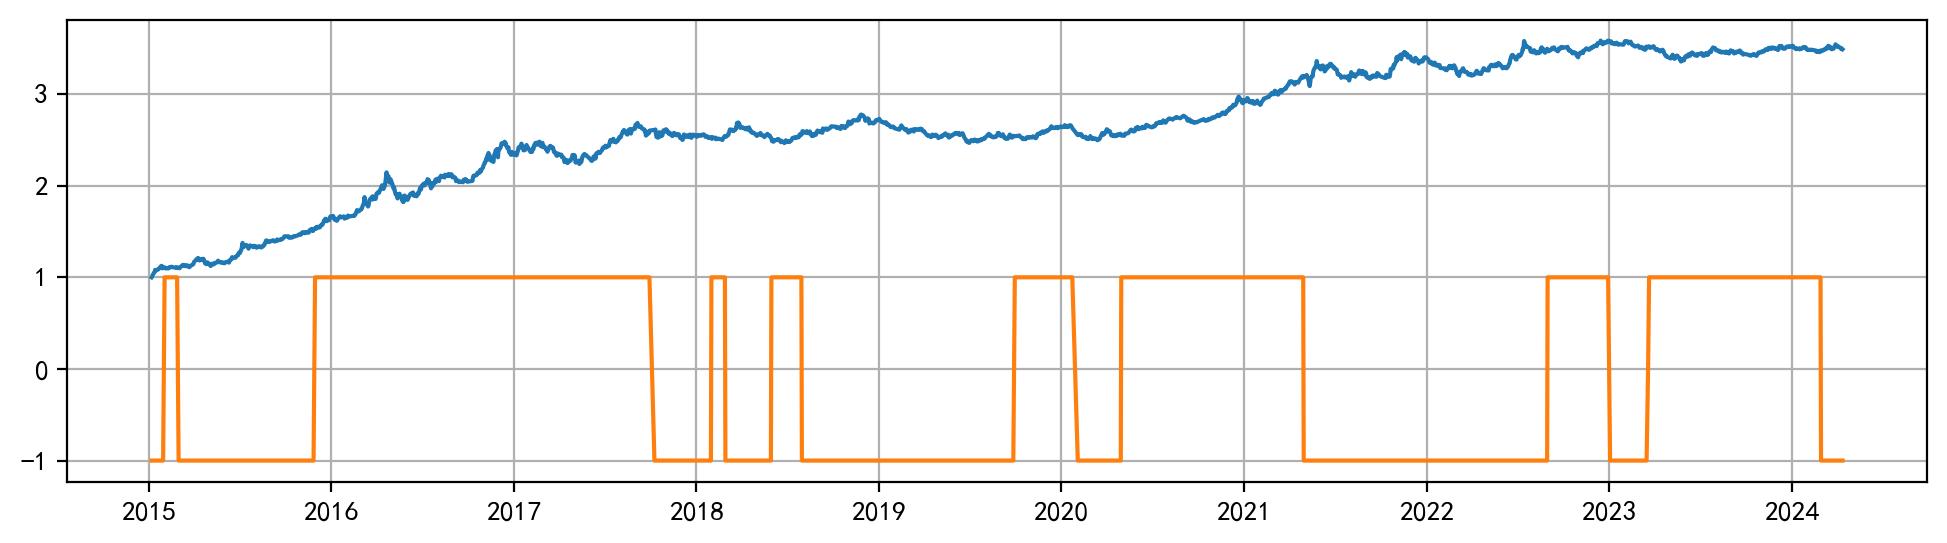

In [27]:
plt.plot(utils.scale(net_worth, "1stvalue"), label='networth')
# plt.plot(utils.scale(prices['hc'], "1stvalue"), label='hc')
plt.plot(utils.scale(posi_comb, how='1stvalue'), label='posi')